# **AML subtype classifier tutorial**

### A few instructions on how to use it:

- The classifier only recognizes TPM gene expression quantification data (obtained by RNA-seq).

- The highly recommended pipeline for obtaining TPM is STAR + RSEM (with a reference genome version ≥ 32).

- The classifier only works on one sample at a time. The input accepted by the classifier is a TSV (tab-separated values) file with a column entitled **gene_id** containing the ENSGs, followed by a **TPM** column containing the gene expression values.

- No log transformation must have been applied to the TPM.
<br/><br/>

### Initialization

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import load
import urllib.request
import os

In [6]:
# Download files if they are not there.
if not os.path.exists("Model"):
    os.makedirs("Model")
if not os.path.exists("Model/features.tsv"):
    urllib.request.urlretrieve("https://nextcloud.computecanada.ca/index.php/s/Ax6fakA2aCSrj3e/download",
                               "Model/features.tsv")
if not os.path.exists("Model/classifier.pkl"):
    urllib.request.urlretrieve("https://nextcloud.computecanada.ca/index.php/s/58Eb4gMGtiBYBWN/download",
                               "Model/classifier.pkl")    


if not os.path.exists("test_data"):
    os.makedirs("test_data")
if not os.path.exists("test_data/sample_example.tsv"):
    urllib.request.urlretrieve("https://nextcloud.computecanada.ca/index.php/s/sP3kmHJ87cDgPXN/download",
                               "test_data/sample_example.tsv")

In [7]:
color_palette = {
    "KMT2At": "#AFDFEF", 
    "t(15;17)": "#08306B",
    "IDH2m": "#E6AB02",
    "NPM1m": "#C70E7B",
    "Chr.Spl.": "#009999",
    "Inter.": "#0079BA",
    "Complex": "#78222E",
    "Mono5/7": "#EE7A1A",
    "NUP98t": "#FFC0CB",
    "t(8;21)": "#6C6C9D",
    "inv(16)": "#DB7676",
    "CEBPAm": "#CF5BE3",
    "MECOMr": "#00A4DB",
    "t(6;9)": "#1C7A3F",
    "others": "#FDAE6B",
    "ETV6t": "#7F38CF",
    "CBFA2T3t": "#A9CC51"
}

### Classification of AML subtypes

In [8]:
# Load features and model
features = pd.read_csv('Model/features.tsv', sep='\t')
with open("Model/classifier.pkl", "rb") as f:
    model = load(f)

In [9]:
def subgroup_classification(sample_data, features, model):
    ## We remove gene ID versions (e.g. ENSG00000000460.16) so that any genome version used for alignment with STAR+RSEM is recognized by the classifier.
    sample_data["gene_id_without_version"] = sample_data["gene_id"].apply(lambda x: x.split('.', 1)[0])
    # Genes with 2 transcripts (e.g. with “_PAR_Y” in the second transcript) are deleted.
    sample_data.drop_duplicates(subset="gene_id_without_version", keep='first', inplace=True)
    del sample_data['gene_id']
    sample_data = sample_data.rename(columns={"gene_id_without_version": "gene_id"})
    # Shift the gene_id column to the first position
    cols = list(sample_data)
    cols.insert(0, cols.pop(cols.index("gene_id")))
    sample_data = sample_data.loc[:, cols]

    ## We keep the genes (ENSG) needed for the classifier (protein-coding genes, excluding those on the sex chromosomes).
    sample_data = features.merge(sample_data, on='gene_id', how='left')
    # For required genes not present in the sample, we replace their expression after merge (NaN) by 0.
    sample_data['TPM'] = sample_data['TPM'].fillna(0)

    ## Data formatting
    sample_data.set_index("gene_id", inplace=True)
    # Log transformation on gene expression data
    sample_data = sample_data.astype(float)
    sample_data = np.log2(sample_data + 1)
    sample_array = sample_data[["TPM"]].T.to_numpy()

    ## Applying the classification model to the sample
    prediction_proba = model.predict_proba(sample_array)
    # We add the equivalences with the names of AML subtypes
    subgroups = [["KMT2At", "KMT2A translocations"],
                 ["t(15;17)", "t(15;17)(q24.1;q21.2)/PML-RARA"],
                 ["IDH2m", "IDH2 R172 mutations"],
                 ["NPM1m", "NPM1 mutations"],
                 ["Chr.Spl.", "Mutations in genes encoding chromatin compaction and/or splicing regulation"],
                 ["Inter.", "Normal or intermediate karyotype"],
                 ["Complex", "Complex karyotype and/or TP53 mutations"],
                 ["Mono5/7", "Monosomy or deletion of 5(q) and/or 7(q)"],
                 ["NUP98t", "NUP98 translocations"],
                 ["t(8;21)", "t(8;21)(q22;q22.1)/RUNX1-RUNX1T1"],
                 ["inv(16)", "inv(16)(p13.1q22)/CBFB-MYH11"],
                 ["CEBPAm", "CEBPA b-Zip in-frame mutations"],
                 ["MECOMr", "MECOM rearrangements"],
                 ["t(6;9)", "t(6;9)(p22.3;q34.1)/DEK-NUP214"],
                 ["others", "AML others"],
                 ["ETV6t", "ETV6 translocations"],
                 ["CBFA2T3t", "inv(16)(p13q24)/CBFA2T3-GLIS2"]]
    # Create the pandas DataFrame
    prediction_df = pd.DataFrame(subgroups, columns=['Subgroup_def', 'Subgroup_fr'])
    prediction_df['Probability'] = prediction_proba.flatten()
    # Sort probabilities in descending order
    prediction_df = prediction_df.sort_values(by="Probability", axis=0, ascending=False)
    prediction_df.reset_index(drop=True, inplace=True)
    prediction_df["Probability"] = prediction_df["Probability"] * 100

    return prediction_df

### Read in your sample here

##### ⚠ **REMINDER**

- The classifier only works on one sample at a time. The input accepted by the classifier is a TSV (tab-separated values) file with a column entitled **gene_id** containing the ENSGs, followed by a **TPM** column containing the gene expression values.

- No log transformation must have been applied to the TPM.
<br/><br/>

The sample used as an example below is BA3192R from patient 2475 of the BeatAML cohort. His AML is caused by a mutation in the *NPM1* gene<sup>[1]</sup>. Gene expression data are freely available<sup>[2]</sup>.

<sup>1. Tyner, J.W., Tognon, C.E., Bottomly, D. and al. Functional genomic landscape of acute myeloid leukaemia. *Nature* **562**, 526–531 (2018). https://doi.org/10.1038/s41586-018-0623-z</sup> <br>
<sup>2. https://portal.gdc.cancer.gov/projects/BEATAML1.0-COHORT </sup>

In [10]:
sample = "test_data/sample_example.tsv"
sample_data = pd.read_csv(sample, sep='\t')

### Applying the classifier

In [11]:
sample_prediction = subgroup_classification(sample_data, features, model)

### Displaying classification results

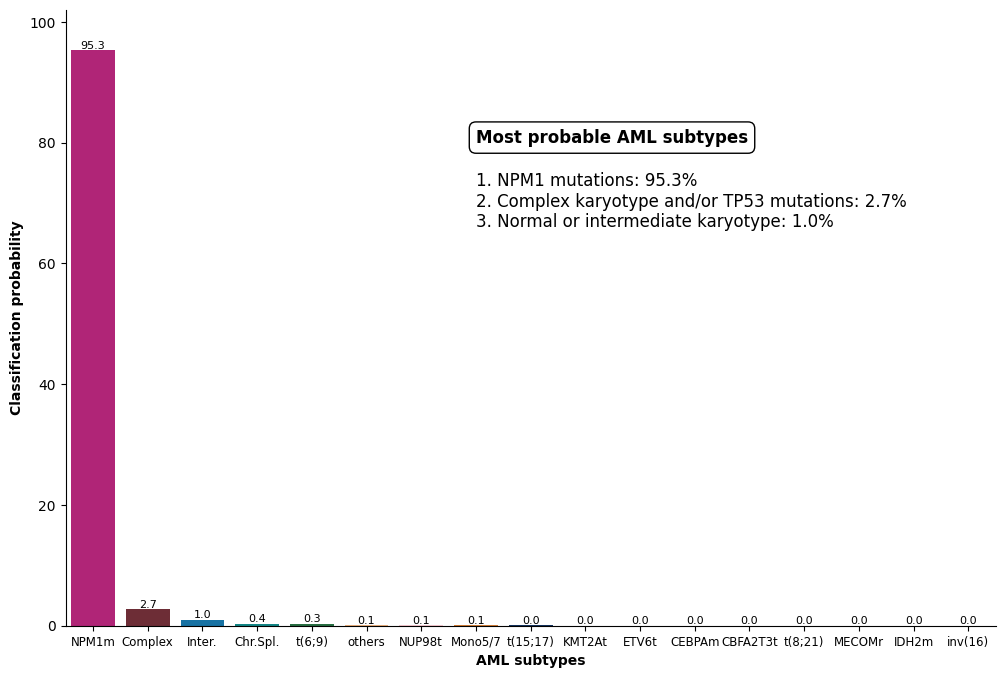

In [12]:
plt.figure(figsize=(12, 8))
bar = sns.barplot(sample_prediction, x="Subgroup_def", y="Probability", hue="Subgroup_def", palette=color_palette, legend=False)
for i in range(len(sample_prediction)):
    bar.text(i, sample_prediction.loc[i, "Probability"]+0.3, str(round(sample_prediction.loc[i, "Probability"], 1)),
             fontdict= dict(fontsize=8),
             horizontalalignment='center')
plt.text(7, 80,
         f"Most probable AML subtypes", 
         fontsize = 12, # Size
         fontweight = "bold",
         ha = "left", # Horizontal alignment
         va = "baseline", # Vertical alignment 
         bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', pad=0.4))
plt.text(7, 66,
         f"1. {sample_prediction.loc[0, 'Subgroup_fr']}: {(sample_prediction.loc[0, 'Probability']):.1f}%\n2. {sample_prediction.loc[1, 'Subgroup_fr']}: {(sample_prediction.loc[1, 'Probability']):.1f}%\n3. {sample_prediction.loc[2, 'Subgroup_fr']}: {(sample_prediction.loc[2, 'Probability']):.1f}%", 
         fontsize = 12, # Size
         ha = "left", # Horizontal alignment
         va = "baseline") # Vertical alignment 
sns.despine()
plt.ylim(0, 102)
plt.xticks(fontsize=8.5)
plt.xlabel("AML subtypes", fontsize=10, fontdict=dict(weight='bold'))
plt.ylabel("Classification probability", fontsize=10, fontdict=dict(weight='bold'))
plt.show()

## Interpreting classification results

| **AML subtypes** | **Prediction rank** | **Probability** | **Recommendation** |
| ---------------- | :-------------------: | :---------------: | ------------------ |
| t(15;17), t(8;21), inv(16), KMT2At, NPM1m | 1 | ≥ 50% | The patient's AML is defined by the main prediction. |
| t(6;9) | 1 | ≥ 30% | The patient's AML is defined by the translocation t(6;9)(p22.3;q34.1)/*DEK-NUP214*. |
| NUP98t, MECOMr, CEBPAm, Complex, Mono5/7, Chr.Spl.<sup>*</sup>, Inter. | 1 | ≥ 40% | The patient's AML is defined by the main prediction. |
| Inter. **AND** CEBPAm | 1 **AND** ∅ | ≥ 40% **AND** ≿ 5% | The patient's AML is defined by a b-Zip in-frame mutation of *CEBPA*. |
| Inter. **AND** CBFA2T3t | 1 **AND** ∅ | ≥ 40% **AND** ≿ 5% | The patient's AML is defined by the inversion inv(16)(p13q24)/*CBFA2T3-GLIS2*. |

<sup>*</sup>The "Chr.Spl." subtype corresponds to AMLs with mutations in genes encoding chromatin compaction and/or regulators of RNA splicing. The genes concerned are *ASXL1*, *BCOR*, *EZH2*, *RUNX1*, *SF3B1*, *SRSF2*, *STAG2*, *U2AF1* and *ZRSR2*.